# 2- k-means Clustering by Semidefinite Programming




In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh, svds, eigs
from math import sqrt
import scipy.io as sio
import random
import numpy.matlib
from helpers import *
import time
from scipy.sparse import isspmatrix
from Llyod_kmeans import *
from proj_L1 import proj_L1

def proj_nuc(Z, kappa):
    #proj_nuc: This function implements the projection onto nuclear norm ball.
     
    U, S, VH = np.linalg.svd(Z,full_matrices = False)
    
    Sigma = np.diag(proj_L1(S, kappa))
   # print(U.shape, S.shape, VH.shape, Sigma.shape)
    return np.dot(U, np.dot(Sigma, VH))

# fix the seed
random.seed( 3 )

In [91]:
# Load data
Problem = sio.loadmat('data/clustering_data.mat')
C = np.double(Problem['C']) # euclidean distance matrix
N = np.int(Problem['N']) # number of data points
k = Problem['k'] # number of clusters
opt_val = Problem['opt_val'] # optimum value 
images = Problem['images'] # images for visualization after clustering
labels = Problem['labels'] # true labels
digits = Problem['digits'] # input data points

In [92]:
print(opt_val)

[[57.05339187]]


### Define operators

1. `A1`: Linear operator that takes the row sums
2. `At2`: Conjugate of operator A1
3. `A2`: Linear operator that takes the column sums 
4. `At2`: Conjugate of operator A2

In [93]:
A1 = lambda x: np.sum(x, axis = 1)
At1 = lambda y: np.transpose(np.matlib.repmat(y, N, 1))
A2 = lambda x: np.sum(x, axis = 0)
At2 = lambda y: (np.matlib.repmat(y, N, 1))

b = np.double(np.ones(N))

In [94]:
def plot_comp(it, f1,f2, obj):
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.loglog(it[0], f1[0], label='PDHG')#, 'go--', linewidth=2, markersize=12))
    plt.loglog(it[1], f1[1], label='HCGM')#, 'go--', linewidth=2, markersize=12))
    plt.xlabel('t (sec)',fontsize=15)
    plt.ylabel('$\|X1-1\|/1$',fontsize=15)
    plt.grid(True)
    

    plt.subplot(222)
    plt.loglog(it[0], f2[0], label='PDHG' )
    plt.loglog(it[1], f2[1], label='HCGM' )
    plt.xlabel('t (sec)',fontsize=15)
    plt.ylabel('dist$(X, \mathbb{R}^{n}_+)$',fontsize=15)
    plt.grid(True)
    plt.show()

    obj_res_PDHG = np.reshape(np.abs(obj[0] - opt_val)/opt_val, (len(obj[0]),))
    obj_res_HCGM = np.reshape(np.abs(obj[1] - opt_val)/opt_val, (len(obj[1]),))
    plt.figure(figsize=(12, 8))
    plt.loglog((it[0]), (obj_res_PDHG), label='PDHG')
    plt.loglog((it[1]), (obj_res_HCGM), label='HCGM')
    plt.xlabel('t (sec)',fontsize=15)
    plt.ylabel('$(f(X) - f^*)/f^*$',fontsize=15)
    plt.title('Relative objective residual',fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.show()

### Algorithm 1. Homotopy CGM



In [95]:
def HCGM(kappa=10, maxit=np.int(1e3), beta0=1):
    # Initialize
    X = np.zeros((N,N))
    AX1_b = 0.0
    
    feasibility1 = [] # norm(A1(X)-b1)/norm(b1)
    feasibility2 = [] # dist(X, \mathcal{K})
    objective    = [] # f(x)
    cur_iter    = []   
    t    = []         # for time tracking
    
    iter_track = np.unique(np.ceil(np.power(2, np.linspace(0,20,50))))
    
    start = time.time()
    
    for iteration in range(1, maxit+1):
        
        # Update Step Size
        gamma = 2.0 / (iteration + 1)
        
        # Update beta
        beta_ = beta0 / np.sqrt(iteration + 1)
        
        # Write down the vk to use in the lmo (eigenvalue routine)
        vk = beta_ * C + At1(A1(X) - b) + At2(A2(X) - b) + 1000 * np.minimum(X, 0) # X - max(X,0)
        vk = 0.5*(vk + vk.T)
        
        # Linear minimization oracle
        q, u = eigsh(vk, k=1, tol=1e-16, which='SA')
        u = sqrt(kappa)*u
        X_bar = np.outer(u,u)
        
        # Obtain A*Xbar - b
        AX_bar_b = A1(X_bar)-b
        
        # Update A*X - b
        AX1_b = (1.0-gamma)*AX1_b + gamma*(AX_bar_b)
        
        # Update X
        X = (1 - gamma) * X + gamma * X_bar
                
        if any(iteration == iter_track) or iteration==maxit:
            feasibility1.append(np.linalg.norm(AX1_b)/N)
            feasibility2.append(np.linalg.norm(np.minimum(X,0), ord='fro'))
            objective.append(np.sum(C.flatten()*X.flatten()))
            cur_iter.append(iteration)
            t.append(time.time()-start)
            print('{:03d} | {:.4e}| {:.4e}| {:.4e}|'.format(iteration, feasibility1[-1], feasibility2[-1],objective[-1]))
            
    return X, feasibility1, feasibility2, objective, cur_iter, t

#### Run HCGM

In [ ]:
X_HCGM, f1_HCGM, f2_HCGM, obj_HCGM, iter_HCGM, time_HCGM = HCGM(10, np.int(5000), 1)

001 | 2.8157e-01| 0.0000e+00| 1.5028e+04|
002 | 7.2775e-02| 2.8124e+00| 4.0633e+03|
003 | 3.8797e-02| 2.8820e+00| 1.7951e+03|
004 | 6.0178e-02| 1.6950e+00| 2.1542e+03|
005 | 4.4115e-02| 1.8916e+00| 2.3621e+03|
006 | 3.9321e-02| 1.3341e+00| 2.1423e+03|
008 | 3.1495e-02| 1.3564e+00| 1.9023e+03|
010 | 2.7986e-02| 1.0876e+00| 1.7042e+03|
013 | 9.1450e-03| 1.1454e+00| 8.7334e+02|
017 | 9.7534e-03| 8.7930e-01| 8.0521e+02|
023 | 1.0672e-02| 6.6643e-01| 8.7141e+02|
030 | 7.5734e-03| 4.7975e-01| 7.2881e+02|
040 | 7.0140e-03| 3.3010e-01| 6.7838e+02|
053 | 4.0745e-03| 3.2327e-01| 5.9426e+02|


### Algorithm 2. Vu-Condat


In [ ]:
def PDHG(kappa=10, maxit=np.int(1e3), beta0=1):
    # Initialize
    X = np.zeros((N,N))
    Xprev = X
    AX1_b = 0.0
    
    y1 = A1(X)
    y2 = A2(X)
    y3 = X
    
    normC = np.linalg.norm(C,'fro')
    
    
    feasibility1 = [] # norm(A1(X)-b1)/norm(b1)
    feasibility2 = [] # dist(X, \mathcal{K})
    objective    = [] # f(x)
    cur_iter    = [] 
    t    = [] 
    
    L = 1e2      
    
    iter_track = np.unique(np.ceil(np.power(2, np.linspace(0,20,50))))
    
    start = time.time()
    # Primal and dual step sizes
    tau = 1/L # primal stepsize
    sigma = 1/(L**2*tau) # dual step size
    sigma2 = sigma*1e4   # different dual step size to use for the update of y3 for better practical performance.

    
    for iteration in range(1, maxit+1):
        
        # Primal variable update
        Xprev = X # store the previous iterate for reflection
        X = proj_nuc(X - tau * ( C + At1(y1) + At2(y2) + y3), kappa )    
        
        # Dual variable updates
        Xhat = 2 * X - Xprev # the point at which the dual gradient is calculated
        y1 = y1 + sigma  * (A1(Xhat) - b ) 
        y2 = y2 + sigma  * (A2(Xhat) - b )
        y3 = y3 + sigma2 *(np.minimum( 1/sigma2 * y3 + Xhat, 0) - 1/sigma2 * y3) #
        
        # Update A*X - b
        AX1_b = A1(X)-b
        
        if any(iteration == iter_track) or iteration==maxit:
            feasibility1.append(np.linalg.norm(AX1_b)/N)
            feasibility2.append(np.linalg.norm(np.minimum(X,0), ord='fro'))
            objective.append(np.sum(C.flatten()*X.flatten()))
            cur_iter.append(iteration)
            t.append(time.time()-start)
            print('{:03d} | {:.4e}| {:.4e}| {:.4e}|'.format(iteration, feasibility1[-1], feasibility2[-1],objective[-1]))
            
    return X, feasibility1, feasibility2, objective, cur_iter, t

#### Run Vu-Condat

In [ ]:
X_PDHG, f1_PDHG, f2_PDHG, obj_PDHG, iter_PDHG, time_PDHG = PDHG(10, np.int(1000), 1)

### Visualize the results

In [ ]:
iters = (iter_PDHG, iter_HCGM)
times = (time_PDHG, time_HCGM)
feas1 = (f1_PDHG, f1_HCGM)
feas2 = (f2_PDHG, f2_HCGM)
obj   = (obj_PDHG, obj_HCGM)
plot_comp(times, feas1,feas2, obj)

In [ ]:
center_HCGM, assign_HCGM = sdp_rounding(X_HCGM,10, digits)
center_PDHG, assign_PDHG = sdp_rounding(X_PDHG,10, digits)

### k-means value: HCGM & Vu-Condat

In [81]:

k_means_before = value_kmeans(digits, labels-1) # k_means value with true labels
k_means_after_HCGM  = value_kmeans(digits, assign_HCGM) # k_means value with assigned lables
k_means_after_PDHG  = value_kmeans(digits, assign_PDHG) # k_means value with assigned lables


print('k-means value initial: {:.4f}'.format(k_means_before))
print('k-means value for HCGM: {:.4f}'.format(k_means_after_HCGM))
print('k-means value for Vu-Condat: {:.4f}'.format(k_means_after_PDHG))

k-means value initial: 150.9680
k-means value for HCGM: 28.7269
k-means value for Vu-Condat: 28.7269


In [89]:
centers_Lloyd, classifications_Lloyd, k_means_Lloyd = kmeans(digits.T, 10)#k_means value with Lloyds k-means algorithm

print('k-means value for Lloyd''s algorithm: {:.4f}'.format(k_means_Lloyd))

k-means value for Lloyds algorithm: 192.4767


# Additional results for clustering fMNIST Data

### Misclassification rates: HCGM & Vu-Condat

In [51]:
print('Misclassification rate for HCGM: {:.4f}'.format(misclassification_rate(assign_HCGM, labels)))
print('Misclassification rate for Vu-Condat: {:.4f}'.format(misclassification_rate(assign_PDHG, labels)))

Misclassification rate for HCGM: 0.1560
Misclassification rate for Vu-Condat: 0.6250


### Visualize samples and predicted labels

In [52]:
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [53]:
def vis_samples(assignment, images, labels):
    assignment=assignment.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    labels = labels-1
    rand_samp = np.random.randint(0,1000,25)
    plt.figure(figsize=(7,7))
    for i,samp in enumerate(rand_samp):
        plt.subplot(5,5,i+1)
        plt.imshow(1-np.reshape(images[samp],[28,28]), cmap=plt.cm.gray)
        plt.title('Pred. {0}\n Orig. {1}'.format(classes[assignment[samp].item()],classes[labels[samp].item()]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

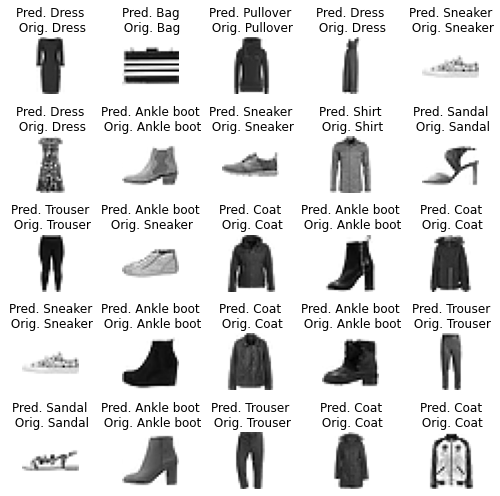

In [54]:
vis_samples(assign_HCGM, images,labels)

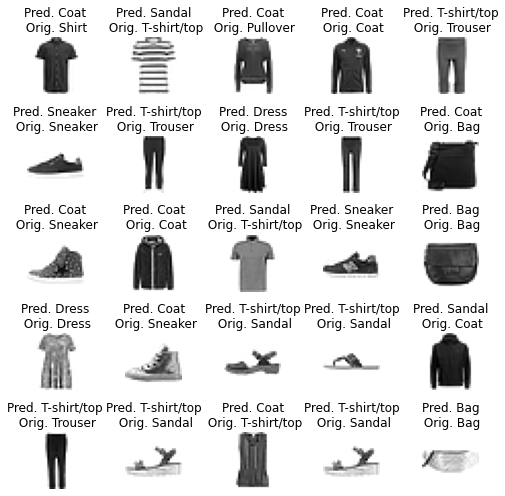

In [55]:
vis_samples(assign_PDHG, images,labels)